# Tuesday Health: Hospice Quality Metrics Technical Assessment
Author: Kyle Biron  

### Imports

In [7]:
import duckdb
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# configure pandas to show full string values and all rows/columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Connect to db

In [8]:
# set duckdb directory path
db_dir = "/Users/kyle/Documents/personal_projects/repos/kyle-tuesday-health-tech-assignment/hospice_quality_metrics/db"

# connect to an existing duckdb database
con = duckdb.connect(f'{db_dir}/hospice_quality_metrics.db')

# list and print all tables in the connected duckdb database
tables = con.execute("SHOW TABLES").df()
print(tables)

                                              name
0                  fact_hospice_provider_flattened
1  fact_hospice_provider_missing_metrics_by_region
2                             stg_hospice_provider


### 1. Correlation Analysis: HIS Composite Process Metric & HCI Decile

#### load ```fact_hospice_provider_flattened``` to a df

- ```fact_hospice_provider_flattened``` is the flattened table from ```hospice_quality_metrics.db``` 
    - ```h_008_01_observed_score``` is the HIS Composite Measure
    - ```h_012_00_observed_score``` is the HCI Decile
- This dataframe will be used for the correlation analysis between the two measures
- Note that ```fact_hospice_provider_flattened``` only contains the CCNs that have BOTH measures populated
    - A side-analyis (see appendix) shows that out of the 7132 CCNs, **2765 (or ~39%)** of CCNs were excluded for this correlation analysis
    - CMS Region 9 (San Francisco: Arizona, California, Hawaii, Nevada, Pacific
Territories) was primarily impacted with this exclusion, as **63.36%** of their CCNs were missing at least one measure 

In [10]:
# use con.execute() to create a df
fact_hospice_provider_flattened_df = con.execute("SELECT * FROM fact_hospice_provider_flattened").df()

# preview the df
fact_hospice_provider_flattened_df.head(5)

,ccn,cms_region,h_008_01_observed_score,h_012_00_observed_score,h_008_01_observed_footnote,h_012_00_observed_footnote
0,241591,5,66.7,8.0,None,None
1,241592,5,99.6,10.0,None,None
2,241593,5,98.9,10.0,None,None
3,241594,5,97.0,10.0,None,None
4,241595,5,99.4,9.0,None,None


#### Examining the distribution of HIS Composite Measure and HCI Decile

- The plots below display the distribution for both measures
- Both measures appear right-skewed, with most of the CCNs "appearing" to perform well on both measures

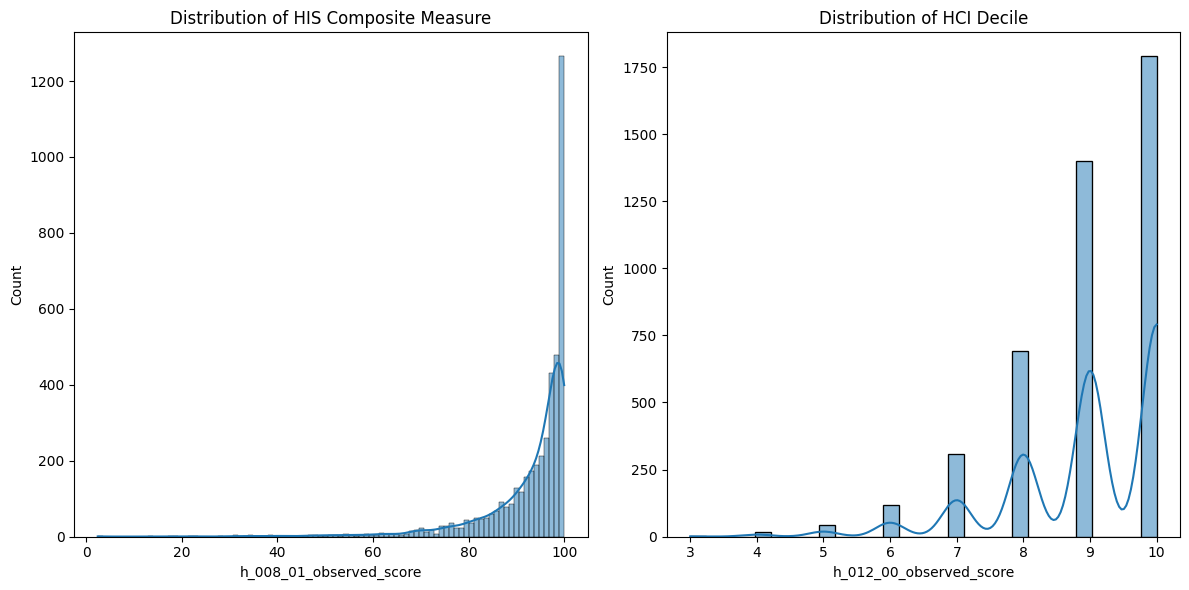

In [11]:
# configure subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# HIS Composite Measure plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_008_01_observed_score", kde=True, ax=axes[0])
axes[0].set_title('Distribution of HIS Composite Measure')

# HCI Decile plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_012_00_observed_score", kde=True, ax=axes[1])
axes[1].set_title('Distribution of HCI Decile')

# show plots
plt.tight_layout()
plt.show()

#### Evaluating the correlation between HIS composite measure and HCI decile

- Initially included only the Pearson correlation coefficient, but since the metric distributions did not meet the normal distribution assumption, the Spearman correlation coefficient was also included
  - The Anderson-Darling test for normality was not used to confirm, but we can clearly see from the histograms that the distributions are not normal 
- Both correlation coefficients (**~0.22**) indicate a **weak positive relationship**, which suggests that these two measures may fundamentally reflect different signals of hospice care quality 

In [12]:
# Pearson correlation
correlation_pearson = fact_hospice_provider_flattened_df[['h_008_01_observed_score', 'h_012_00_observed_score']].corr()

# Spearman correlation
correlation_spearman = fact_hospice_provider_flattened_df[['h_008_01_observed_score', 'h_012_00_observed_score']].corr(method='spearman')

# report out correlation coefficients
print("Correlation Matrix: Pearson\n")
print(correlation_pearson)
print("\n" + "-"*50 + "\n") 
print("Correlation Matrix: Spearman\n")
print(correlation_spearman)

Correlation Matrix: Pearson

                         h_008_01_observed_score  h_012_00_observed_score
h_008_01_observed_score                 1.000000                 0.223246
h_012_00_observed_score                 0.223246                 1.000000

--------------------------------------------------

Correlation Matrix: Spearman

                         h_008_01_observed_score  h_012_00_observed_score
h_008_01_observed_score                 1.000000                 0.227345
h_012_00_observed_score                 0.227345                 1.000000


- Even by evaluating the Spearman coefficient by ```cms_region```, we do not observe any significant improvement in the correlation between the HIS composite measure and the HCI decile
- Region 10 has arguably the "strongest" relationship (**~0.28**) between HIS composite measure and the HCI decile, whereas Region 4 has little to no relationship (**~0.04**)
    - 10 = Seattle: Alaska, Idaho, Oregon, Washington
    - 4 = Atlanta: Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee      

In [13]:

# Spearman correlation by region
correlation_spearman_by_region = fact_hospice_provider_flattened_df.groupby('cms_region')[
    ['h_008_01_observed_score', 'h_012_00_observed_score']
].corr(method='spearman')

# report out correlation coefficients
print("Correlation Matrix: Spearman by cms_region\n")
print(correlation_spearman_by_region)

Correlation Matrix: Spearman by cms_region

                                    h_008_01_observed_score  h_012_00_observed_score
cms_region                                                                          
1          h_008_01_observed_score                 1.000000                 0.174107
           h_012_00_observed_score                 0.174107                 1.000000
2          h_008_01_observed_score                 1.000000                 0.205653
           h_012_00_observed_score                 0.205653                 1.000000
3          h_008_01_observed_score                 1.000000                 0.253217
           h_012_00_observed_score                 0.253217                 1.000000
4          h_008_01_observed_score                 1.000000                 0.044258
           h_012_00_observed_score                 0.044258                 1.000000
5          h_008_01_observed_score                 1.000000                 0.155562
           h_012_00_o

In summary:
- HIS composite measure and HCI decile are only **slightly** related (positive direction)
- **Pros** of HIS composite process metric
  - HIS captures patient-level data on admissions and discharges, which indicates more of a process-specific measure
  - Being a process-specific measure facilitates easier data collection for CCNs
  - References: [HIS Manual](https://www.cms.gov/files/document/hismanualv302apr152024.pdf)
- **Cons** of HIS composite process metric
  - Again, since this measure captures data on admissions and discharges, signals regarding cost and utilization may not be captured
  - In other words, there are CCNs who perform well on adhering to the administrative processes of admission/discharges, but perform poorly on cost/utilization/outcomes (i.e. CCN:111743, HIS: 100, HIC: 4.0)
  - Scatterplot below highlights some of these patterns
  - In general (not just specific to HIS), there is variability of measure availability across all **cms_region**, indicating some regions have less hospice resources and than others 

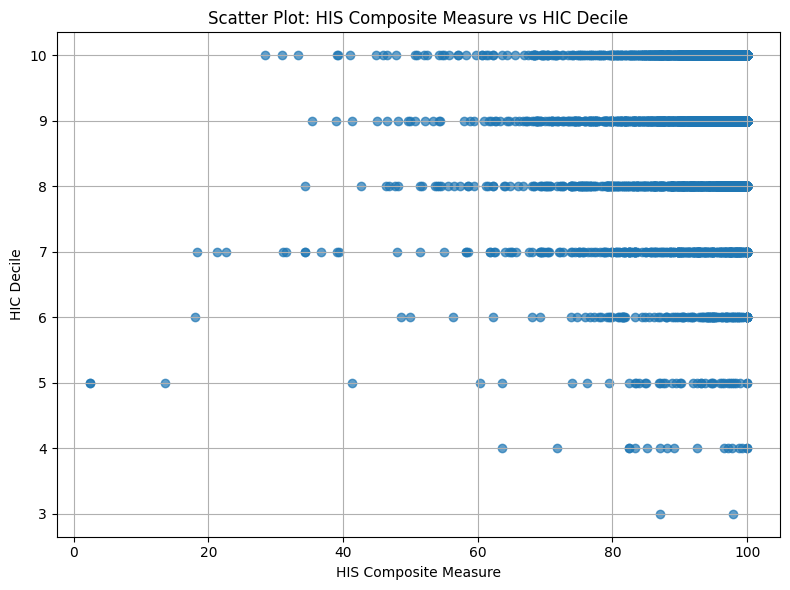

In [14]:
plt.figure(figsize=(8, 6))

# Create a scatter plot
plt.scatter(fact_hospice_provider_flattened_df['h_008_01_observed_score'], 
            fact_hospice_provider_flattened_df['h_012_00_observed_score'], 
            alpha=0.7)

# Set the title and labels
plt.title('Scatter Plot: HIS Composite Measure vs HIC Decile')
plt.xlabel('HIS Composite Measure')
plt.ylabel('HIC Decile')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### Appendix

####  CCNs without having both HIS and HCI by region

referenced from the data dictionary:  
- 1 = Boston: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont  
- 2 = New York: New Jersey, New York, Puerto Rico, Virgin Islands  
- 3 = Philadelphia: Delaware, District of Columbia, Maryland, Pennsylvania, Virginia, West Virginia  
- 4 = Atlanta: Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee  
- 5 = Chicago: Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin  
- 6 = Dallas: Arkansas, Louisiana, New Mexico, Oklahoma, Texas  
- 7 = Kansas City: Iowa, Kansas, Missouri, Nebraska  
- 8 = Denver: Colorado, Montana, North Dakota, South Dakota, Utah, Wyoming  
- 9 = San Francisco: Arizona, California, Hawaii, Nevada, Pacific Territories  
- 10 = Seattle: Alaska, Idaho, Oregon, Washington

<Figure size 1000x600 with 0 Axes>

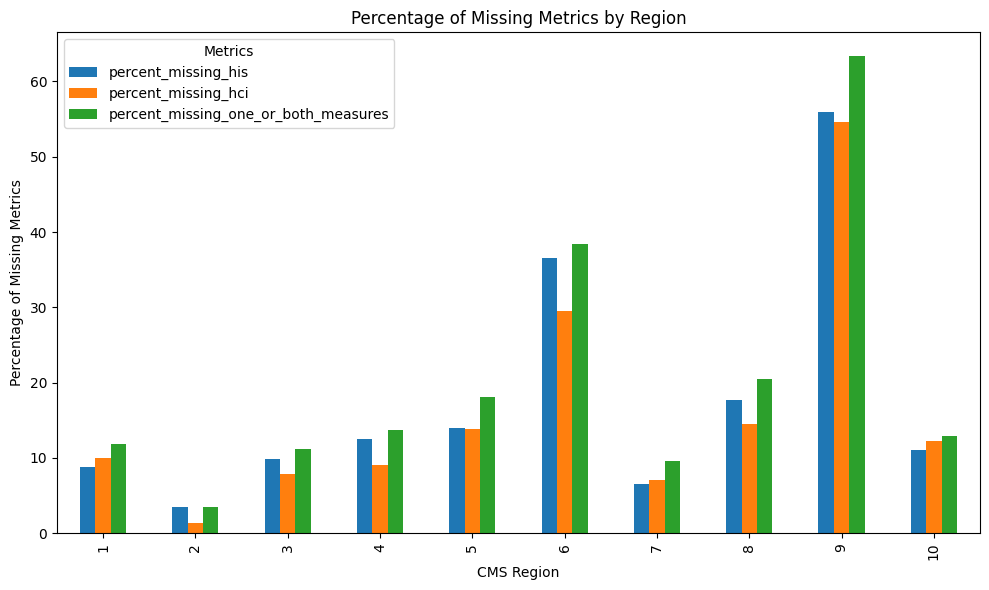

In [15]:
# use con.execute() to create a df
fact_hospice_provider_missing_metrics_by_region_df = con.execute("SELECT * FROM fact_hospice_provider_missing_metrics_by_region").df()

# sort df by cms_region
fact_hospice_provider_missing_metrics_by_region_df = fact_hospice_provider_missing_metrics_by_region_df.sort_values('cms_region')

# configure size
plt.figure(figsize=(10, 6))

# bar chart
fact_hospice_provider_missing_metrics_by_region_df.plot(
    kind='bar', 
    x='cms_region', 
    y=['percent_missing_his', 'percent_missing_hci', 'percent_missing_one_or_both_measures'], 
    figsize=(10, 6)
)

# configure title and labels
plt.title('Percentage of Missing Metrics by Region')
plt.xlabel('CMS Region')
plt.ylabel('Percentage of Missing Metrics')

# show plot
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

In [5]:
adhoc_query = '''

select 
        *,
        (h_012_00_observed_score * 10) - h_008_01_observed_score as measure_gap
    from fact_hospice_provider_flattened
    order by measure_gap asc
    limit 10

'''

con.execute(adhoc_query).df()

,ccn,cms_region,h_008_01_observed_score,h_012_00_observed_score,h_008_01_observed_footnote,h_012_00_observed_footnote,measure_gap
0,851518,4,97.9,3.0,None,None,-67.9
1,111743,4,100.0,4.0,None,None,-60.0
2,251606,4,100.0,4.0,None,None,-60.0
3,A11677,9,99.3,4.0,None,None,-59.3
4,441604,4,98.8,4.0,None,None,-58.8
5,551523,9,97.7,4.0,None,None,-57.7
6,A01666,9,97.2,4.0,None,None,-57.2
7,A11700,9,87.1,3.0,None,None,-57.1
8,A11726,9,96.6,4.0,None,None,-56.6
9,A11509,9,92.6,4.0,None,None,-52.6


In [81]:
con.close()